# Laboratorium 2


### Konfiguracja

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes

    def set_axis(self, ax):
        self.ax = ax
        
    def next(self, event):
        self.i = (self.i + 1) % len(scenes)
        self.draw()

    def prev(self, event):
        self.i = (self.i - 1) % len(scenes)
        self.draw()
        
    def draw(self):
        self.ax.clear()
        for collection in scenes[self.i].points:
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), c=collection.color, marker=collection.marker)
        for collection in scenes[self.i].lines:
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale()
        plt.draw()

### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

class PointsCollection:
    def __init__(self, points = [], color = None, marker = None):
        self.points = np.array(points)
        self.color = color
        self.marker = marker

class LinesCollection:
    def __init__(self, lines = [], color = None):
        self.color = color
        self.lines = lines
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        if self.color:
            return mcoll.LineCollection(self.lines, colors=mcolors.to_rgba(self.color))
        else:
            return mcoll.LineCollection(self.lines)
            


class Plot:
    def __init__(self, scenes = [], json = None):
        if json is None:
            self.scenes = scenes
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
        
    def __configure_buttons(self, callback):
        plt.subplots_adjust(bottom=0.2)
        axprev = plt.axes([0.6, 0.05, 0.15, 0.075])
        axnext = plt.axes([0.76, 0.05, 0.15, 0.075])
        bnext = Button(axnext, 'Następny')
        bnext.on_clicked(callback.next)
        bprev = Button(axprev, 'Poprzedni')
        bprev.on_clicked(callback.prev)
        return [bprev, bnext]

    def draw(self):
        plt.close()
        callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons(callback)
        callback.set_axis(plt.axes())
        plt.show()
        callback.draw()
        
    def toJSON(self):
        return js.dumps([{"points": [pointCol.points.tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])
    

### Przykład użycia

In [3]:
# %matplotlib notebook

# scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
#                PointsCollection([(5, -2), (2, 2), (-2, -1)], 'green', marker = "^")], 
#               [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]], 'orange')]), 
#         Scene([PointsCollection([(1, 2), (-15, 1.5), (2, -1)], 'red'), 
#                PointsCollection([(5, -2), (2, 2), (-2, 1)], 'black')], 
#               [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

# plot = Plot(scenes)
# plot.draw() 


### Rozwiązanie

Czas dzialania algorytmu dla czterach zbiorów:  0.0019998550415039062


<IPython.core.display.Javascript object>


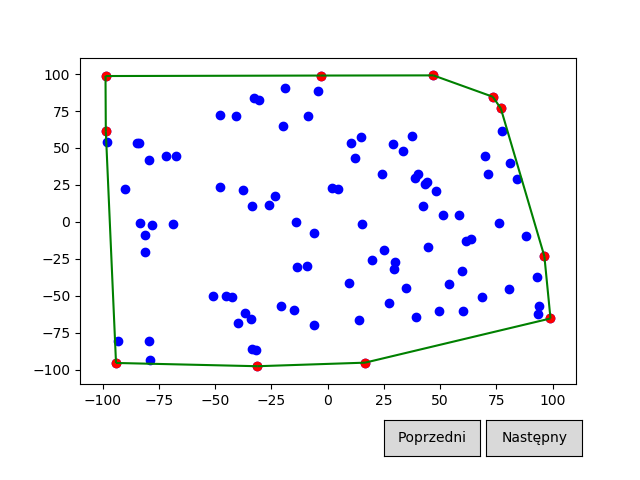

In [9]:
%matplotlib notebook

import math
import random
import time

# zadanie 3 ###
def genA(l, r, n):
    points = []
    for x in range(n):
        points.append((random.uniform(l, r), random.uniform(l, r)))
    return points


def genB(A, R, n):
    points = []
    for x in range(n):
        p = random.uniform(0,2 * math.pi)
        points.append(((math.sin(p) * R) + A[0],
                       (math.cos(p) * R + A[1])))
    return points


def genC(A, B, C, D, n):
    points = []
    for x in range(n):
        side = random.randint(1,4)
        if side == 1:  # A-B
            points.append((A[0], random.uniform(A[1], B[1])))
        elif side == 2:  # B-C
            points.append((random.uniform(B[0], C[0]), B[1]))
        elif side == 3:  # C-D
            points.append((C[0], random.uniform(C[1], D[1])))
        else:  # D-A
            points.append((random.uniform(A[0], D[0]), A[1]))
    return points


def genD(A, B, C, D, no, np):
    points = []
    for x in range(no):
        points.append((random.uniform(0, B[0]), 0))
        points.append((0, random.uniform(0, D[1])))
    for x in range(np):
        place = random.uniform(0, B[0])
        points.append((place, place))
        place = random.uniform(0, B[0])
        points.append((place, B[0] - place))
    return points
# ###


# funkcja liczaca kąt nachylenia do osi 0X ###
def slope_to_OX(a, b):
    if a[0] == b[0] and a[1] == b[1]:
        return None
    if a[0] == b[0]:
        return 'X'
    if a[1] == b[1]:
        return 'Y'
    return (a[1] - b[1]) / (a[0] - b[0])
    # ###


# funkcja liczaca wyznacznik ###
def determinant(a, b, c):
    return ((a[0] - c[0]) * (b[1] - c[1])) - ((a[1] - c[1]) * (b[0] - c[0]))
# >0 => lewa strona
# <0 => prawa strona
# =0 => na linii
# ###


# algorytm Grahama ###
def Graham(points):
    points.sort(key=lambda x: (x[1], x[0]))
    p0 = points[0]

    share_x_with_p0 = []
    share_y_with_p0 = []
    positive_slope = []
    negative_slope = []

    for point in points:
        slope = (slope_to_OX(p0, point), point)

        if slope[0] is None:
            continue
        elif slope[0] == 'X':
            share_x_with_p0.append(slope)
        elif slope[0] == 'Y':
            share_y_with_p0.append(slope)
        elif slope[0] > 0:
            positive_slope.append(slope)
        else:
            negative_slope.append(slope)

    share_x_with_p0.sort(key=lambda x: x[1][1], reverse=True)
    share_y_with_p0.sort(key=lambda x: x[1][0], reverse=True)
    positive_slope.sort(key=lambda x: (x[0], x[1][0]))
    negative_slope.sort(key=lambda x: (x[0], x[1][0]))

    slopes = []

    if share_y_with_p0 != []:
        slopes.append(share_y_with_p0[0][1])
    tmp = []
    for point in positive_slope:
        if tmp == [] or point[0] == tmp[len(tmp) - 1][0]:
            tmp.append(point)
        else:
            slopes.append(tmp[len(tmp) - 1][1])
            tmp.append(point)
    if tmp != []: slopes.append(tmp[len(tmp) - 1][1])

    if share_x_with_p0 != []: slopes.append(share_x_with_p0[0][1])
    tmp = []
    for point in negative_slope:
        if tmp == [] or point[0] == tmp[len(tmp) - 1][0]:
            tmp.append(point)
        else:
            slopes.append(tmp[len(tmp) - 1][1])
            tmp.append(point)
    if tmp != []: slopes.append(tmp[len(tmp) - 1][1])
    slopes.insert(0, p0)

    i = 3
    stack = []
    stack.append(slopes[0])
    stack.append(slopes[1])
    stack.append(slopes[2])

    while i < len(slopes):
        j = len(stack) - 2

        det = determinant(stack[j], stack[j + 1], slopes[i])
        if det > 0:
            stack.append(slopes[i])
            i += 1
        elif det < 0:
            stack.pop()
        else:
            stack.pop()
            stack.append(slopes[i])
            i += 1

    return stack
# koniec algorytmu Grahama ###

# tworzenie linii ze zbioru punktów ###
def tworzenie_linii(punkty):
    linie = []
    for i in range(len(punkty)):
        if i > 0:
            linie.append([punkty[i-1], punkty[i]])
    linie.append([punkty[0], punkty[len(punkty) - 1]])
    return linie
# ###

A = genA(-100, 100, 100)
B = genB((0, 0), 10, 100)
C = genC((-10, 10), (-10, -10), (10, -10), (10, 10), 100)
D = genD((0, 0), (10, 0), (10, 10), (0, 10), 25, 20)


start = time.time()

otoczkaA = Graham(A)
otoczkaB = Graham(B)
otoczkaC = Graham(C)
otoczkaD = Graham(D)

end = time.time()
print("Czas dzialania algorytmu dla czterach zbiorów: ", end - start)

linie_otoczka_a = tworzenie_linii(otoczkaA)
linie_otoczka_b = tworzenie_linii(otoczkaB)
linie_otoczka_c = tworzenie_linii(otoczkaC)
linie_otoczka_d = tworzenie_linii(otoczkaD)


scenes=[Scene([PointsCollection(A, color = 'blue'),
               PointsCollection(otoczkaA, color = 'red')],
              [LinesCollection(linie_otoczka_a, color = 'green')]),
        Scene([PointsCollection(B, color = 'blue'),
               PointsCollection(otoczkaB, color = 'red')],
              [LinesCollection(linie_otoczka_b, color = 'green')]),
        Scene([PointsCollection(C, color = 'blue'),
               PointsCollection(otoczkaC, color = 'red')],
              [LinesCollection(linie_otoczka_c, color = 'green')]),
        Scene([PointsCollection(D, color = 'blue'),
               PointsCollection(otoczkaD, color = 'red')],
              [LinesCollection(linie_otoczka_d, color = 'green')])]
plot = Plot(scenes)
plot.draw()